<a href="https://colab.research.google.com/github/BonaldSo/project_adversarialTraining/blob/main/MyAdversarialTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%pip install umap-learn==0.5.2
%pip install torchattacks
import torch
import torchvision
import numpy as np
from sklearn.model_selection import train_test_split
from torchvision import transforms
from collections import Counter
import matplotlib.pyplot as plt
import torchvision.models as models
import umap.umap_ as umap
from tqdm import tqdm
import torch.nn as nn
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import random
from torchattacks import FGSM

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 6.0 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.2-py3-none-any.whl size=82684 sha256=61bc59571d1b59b53e964940aff9283e0c071e0f1536b550813767cdd0333e53
  Stored in directory: /root/.cache/pip/wheels/ff/50/f5/c6dc74059096b9bd10a4446d33ad53748c67850e5c73eb85bd
Successfully built umap-learn
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.0/142.0 kB 4.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.8/143.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 58.7 MB/s eta 0:00:00
     ━━━━━━━━━━━

/usr/local/lib/python3.10/dist-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/usr/local/lib/python3.10/dist-packages/umap/distances.py:1086: NumbaDeprecationWarning: The 'nopython' keyword argume

In [ ]:
device=torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
Train_SIZE = 0.2
cifar_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to range [-1, 1]
])
cifar_trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
cifar_testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True)


100%|██████████| 170498071/170498071 [00:03<00:00, 43776784.49it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
class Cifar10Dataset(torch.utils.data.Dataset):

    def __init__(self,dataset,idx,transforms=None):
        self.idx = idx
        self.transforms = transforms
        self.data = torch.utils.data.Subset(dataset, idx)

    def __getitem__(self,index):
        image,label = self.data[index]
        if(self.transforms!= None):
            image = self.transforms(image)

        return image,label

    def __len__(self):
        return len(self.data)

# Get the indices for each class
class_indices = {label: [] for label in range(10)}
for idx, (_, label) in enumerate(cifar_trainset):
    class_indices[label].append(idx)

# Split indices for each class into training and validation
train_indices = []
val_indices = []
for label, indices in class_indices.items():
    train_idx, val_idx = train_test_split(indices, train_size=Train_SIZE, stratify=[label]*len(indices))
    train_indices.extend(train_idx)
    val_indices.extend(val_idx)

# Create datasets and data loaders
train_dataset = Cifar10Dataset(cifar_trainset, train_indices, transforms=cifar_transforms)
val_dataset = Cifar10Dataset(cifar_trainset, val_indices, transforms=cifar_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)

In [ ]:
class Resnet18(nn.Module):
    def __init__(self, num_classes,normalize = False):
        super().__init__()
        self.resnet18 = models.resnet18(pretrained=False)
        self.fc = nn.Linear(1000, num_classes)
        self.backbone = list(self.resnet18.children())[:-2]
        self.backbone = nn.Sequential(*self.backbone)

    def forward(self, x, mode = False):
        if mode:
            deep = self.backbone
            return deep(x)
        x = self.resnet18(x)
        x = self.fc(x)
        return x

In [ ]:
def train(model,data_loader,criterion,optimizer,attack = False):

    model.train()
    totalloss = 0.0
    correct = 0
    total = 0

    with tqdm(data_loader, desc ="   train") as train_tqdm:
        for batch_idx, (inputs, targets) in enumerate(train_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            #To do
            if attack == True:
                newmodel = FGSM(model, 0.3)
                inputs = newmodel(inputs, targets)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            totalloss += loss.item()
            total += (pred >= 0).sum().item()
            correct += torch.sum(pred == targets).item()

    accuracy = 100. * correct / total
    average_train_loss = totalloss / len(data_loader)


    return average_train_loss, accuracy

In [ ]:
def test(model,data_loader,criterion,optimizer,attack=False):

    model.eval()
    totalloss = 0.
    correct = 0
    total = 0

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            #To do
            if attack == True:
                newmodel = FGSM(model, 0.3)
                inputs = newmodel(inputs, targets)
            optimizer.zero_grad()
            outputs = model(inputs)
            _, pred = torch.max(outputs, 1)
            loss = criterion(outputs, targets)
            totalloss += loss.item()
            total += (pred >= 0).sum().item()
            correct += torch.sum(pred == targets).item()

    accuracy = 100. * correct / total
    average_test_loss = totalloss / len(data_loader)

    return average_test_loss, accuracy

In [ ]:
def plot_umap(features,y):
    #To do
    reducer = umap.UMAP(random_state=42)
    train = reducer.fit_transform(features)
    plt.figure(figsize = (10, 7))
    plt.scatter(train[:, 0], train[:, 1], c = y, s=5)
    plt.gca().set_aspect('equal', 'datalim')
    plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
    plt.title('UMAP projection')
    plt.show()


In [ ]:
# training with train data normally
numclass = 10
model = Resnet18(numclass)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

loss = 0
accuracy = 0

for epoch in range(0, 100):
    loss, accuracy = train(model, train_loader, criterion, optimizer)
    print("train loss: ", loss)
    print("train accuracy: ", accuracy)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
   train: 100%|██████████| 79/79 [00:12<00:00,  6.13it/s]


train loss:  1.812839669517324
train accuracy:  35.71


   train: 100%|██████████| 79/79 [00:11<00:00,  6.76it/s]


train loss:  1.3986593877212912
train accuracy:  49.79


   train: 100%|██████████| 79/79 [00:10<00:00,  7.54it/s]


train loss:  1.1848035205768634
train accuracy:  57.38


   train: 100%|██████████| 79/79 [00:06<00:00, 12.73it/s]


train loss:  1.0483592680737943
train accuracy:  62.34


   train: 100%|██████████| 79/79 [00:05<00:00, 14.84it/s]


train loss:  0.8710155268258686
train accuracy:  69.11


   train: 100%|██████████| 79/79 [00:05<00:00, 14.32it/s]


train loss:  0.7534525024740002
train accuracy:  73.99


   train: 100%|██████████| 79/79 [00:05<00:00, 14.27it/s]


train loss:  0.6151825993121425
train accuracy:  79.05


   train: 100%|██████████| 79/79 [00:05<00:00, 14.69it/s]


train loss:  0.5253296336041221
train accuracy:  81.91


   train: 100%|██████████| 79/79 [00:05<00:00, 13.76it/s]


train loss:  0.4297433686030062
train accuracy:  86.04


   train: 100%|██████████| 79/79 [00:05<00:00, 14.69it/s]


train loss:  0.40182554080516475
train accuracy:  86.07


   train: 100%|██████████| 79/79 [00:05<00:00, 13.63it/s]


train loss:  0.3192394536130036
train accuracy:  88.97


   train: 100%|██████████| 79/79 [00:05<00:00, 14.57it/s]


train loss:  0.19149902651581582
train accuracy:  93.72


   train: 100%|██████████| 79/79 [00:05<00:00, 13.50it/s]


train loss:  0.20434134396948392
train accuracy:  93.21


   train: 100%|██████████| 79/79 [00:05<00:00, 14.79it/s]


train loss:  0.18248092279404024
train accuracy:  93.79


   train: 100%|██████████| 79/79 [00:05<00:00, 13.53it/s]


train loss:  0.24689408948149863
train accuracy:  92.01


   train: 100%|██████████| 79/79 [00:06<00:00, 12.14it/s]


train loss:  0.23228338954946662
train accuracy:  92.25


   train: 100%|██████████| 79/79 [00:06<00:00, 12.20it/s]


train loss:  0.13741660047369667
train accuracy:  95.65


   train: 100%|██████████| 79/79 [00:05<00:00, 14.84it/s]


train loss:  0.12248048073128809
train accuracy:  96.12


   train: 100%|██████████| 79/79 [00:05<00:00, 13.54it/s]


train loss:  0.13906482880628562
train accuracy:  96.17


   train: 100%|██████████| 79/79 [00:05<00:00, 14.87it/s]


train loss:  0.12097901178971876
train accuracy:  95.76


   train: 100%|██████████| 79/79 [00:05<00:00, 13.58it/s]


train loss:  0.09963015610752982
train accuracy:  96.59


   train: 100%|██████████| 79/79 [00:05<00:00, 15.10it/s]


train loss:  0.09280373318757437
train accuracy:  97.43


   train: 100%|██████████| 79/79 [00:05<00:00, 14.24it/s]


train loss:  0.19638848167997372
train accuracy:  93.75


   train: 100%|██████████| 79/79 [00:05<00:00, 14.26it/s]


train loss:  0.057809389361380775
train accuracy:  98.12


   train: 100%|██████████| 79/79 [00:05<00:00, 14.93it/s]


train loss:  0.17220301212318526
train accuracy:  94.85


   train: 100%|██████████| 79/79 [00:05<00:00, 13.69it/s]


train loss:  0.07961691394919836
train accuracy:  97.6


   train: 100%|██████████| 79/79 [00:05<00:00, 14.90it/s]


train loss:  0.08951311796620677
train accuracy:  97.36


   train: 100%|██████████| 79/79 [00:05<00:00, 13.71it/s]


train loss:  0.06966779443517893
train accuracy:  97.6


   train: 100%|██████████| 79/79 [00:05<00:00, 14.86it/s]


train loss:  0.03402902513869178
train accuracy:  98.91


   train: 100%|██████████| 79/79 [00:05<00:00, 13.62it/s]


train loss:  0.04980279193436609
train accuracy:  98.34


   train: 100%|██████████| 79/79 [00:05<00:00, 15.03it/s]


train loss:  0.03398177809895405
train accuracy:  98.96


   train: 100%|██████████| 79/79 [00:05<00:00, 13.88it/s]


train loss:  0.12813410963391578
train accuracy:  96.13


   train: 100%|██████████| 79/79 [00:05<00:00, 14.87it/s]


train loss:  0.1124982025144221
train accuracy:  96.36


   train: 100%|██████████| 79/79 [00:05<00:00, 13.74it/s]


train loss:  0.08977942776430069
train accuracy:  97.16


   train: 100%|██████████| 79/79 [00:05<00:00, 14.19it/s]


train loss:  0.10413653130607703
train accuracy:  96.84


   train: 100%|██████████| 79/79 [00:05<00:00, 14.81it/s]


train loss:  0.08867700300709921
train accuracy:  97.21


   train: 100%|██████████| 79/79 [00:05<00:00, 14.01it/s]


train loss:  0.09514058529859103
train accuracy:  97.56


   train: 100%|██████████| 79/79 [00:05<00:00, 14.94it/s]


train loss:  0.1003272891563328
train accuracy:  97.16


   train: 100%|██████████| 79/79 [00:05<00:00, 13.73it/s]


train loss:  0.14229024267059903
train accuracy:  95.74


   train: 100%|██████████| 79/79 [00:05<00:00, 14.60it/s]


train loss:  0.059829911983371536
train accuracy:  98.26


   train: 100%|██████████| 79/79 [00:05<00:00, 13.58it/s]


train loss:  0.058195929119622784
train accuracy:  98.26


   train: 100%|██████████| 79/79 [00:05<00:00, 15.11it/s]


train loss:  0.04632914817856648
train accuracy:  98.6


   train: 100%|██████████| 79/79 [00:05<00:00, 13.59it/s]


train loss:  0.04955039631363146
train accuracy:  98.77


   train: 100%|██████████| 79/79 [00:05<00:00, 14.59it/s]


train loss:  0.09652516056040797
train accuracy:  97.31


   train: 100%|██████████| 79/79 [00:05<00:00, 13.84it/s]


train loss:  0.08124412361626761
train accuracy:  97.69


   train: 100%|██████████| 79/79 [00:05<00:00, 14.04it/s]


train loss:  0.028394608812913582
train accuracy:  99.05


   train: 100%|██████████| 79/79 [00:05<00:00, 13.92it/s]


train loss:  0.04530785113861902
train accuracy:  98.77


   train: 100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


train loss:  0.09032665791661962
train accuracy:  97.35


   train: 100%|██████████| 79/79 [00:05<00:00, 14.69it/s]


train loss:  0.09724456069495858
train accuracy:  97.17


   train: 100%|██████████| 79/79 [00:06<00:00, 12.66it/s]


train loss:  0.08266392678517519
train accuracy:  97.66


   train: 100%|██████████| 79/79 [00:05<00:00, 14.68it/s]


train loss:  0.04276497478308038
train accuracy:  98.79


   train: 100%|██████████| 79/79 [00:05<00:00, 13.46it/s]


train loss:  0.06976898886923548
train accuracy:  98.03


   train: 100%|██████████| 79/79 [00:05<00:00, 14.86it/s]


train loss:  0.02775070770007051
train accuracy:  99.21


   train: 100%|██████████| 79/79 [00:05<00:00, 13.69it/s]


train loss:  0.02468995739856169
train accuracy:  99.32


   train: 100%|██████████| 79/79 [00:05<00:00, 14.78it/s]


train loss:  0.06926337423840467
train accuracy:  97.94


   train: 100%|██████████| 79/79 [00:05<00:00, 13.56it/s]


train loss:  0.06745468965389684
train accuracy:  98.06


   train: 100%|██████████| 79/79 [00:05<00:00, 14.69it/s]


train loss:  0.021203435472613556
train accuracy:  99.37


   train: 100%|██████████| 79/79 [00:05<00:00, 13.62it/s]


train loss:  0.014208040056128314
train accuracy:  99.53


   train: 100%|██████████| 79/79 [00:05<00:00, 14.62it/s]


train loss:  0.012669284636806107
train accuracy:  99.66


   train: 100%|██████████| 79/79 [00:05<00:00, 13.88it/s]


train loss:  0.08750863004876655
train accuracy:  97.27


   train: 100%|██████████| 79/79 [00:05<00:00, 14.46it/s]


train loss:  0.06508265236463351
train accuracy:  97.89


   train: 100%|██████████| 79/79 [00:05<00:00, 13.96it/s]


train loss:  0.020137162386923084
train accuracy:  99.58


   train: 100%|██████████| 79/79 [00:05<00:00, 14.11it/s]


train loss:  0.07451853764691402
train accuracy:  97.99


   train: 100%|██████████| 79/79 [00:05<00:00, 14.70it/s]


train loss:  0.11797069883139073
train accuracy:  96.64


   train: 100%|██████████| 79/79 [00:05<00:00, 13.90it/s]


train loss:  0.032077310332192896
train accuracy:  98.99


   train: 100%|██████████| 79/79 [00:05<00:00, 14.80it/s]


train loss:  0.028616335315930455
train accuracy:  99.46


   train: 100%|██████████| 79/79 [00:05<00:00, 13.37it/s]


train loss:  0.10787975348980178
train accuracy:  96.85


   train: 100%|██████████| 79/79 [00:05<00:00, 14.56it/s]


train loss:  0.06274437615530024
train accuracy:  98.24


   train: 100%|██████████| 79/79 [00:05<00:00, 13.53it/s]


train loss:  0.03888407029812755
train accuracy:  98.81


   train: 100%|██████████| 79/79 [00:05<00:00, 14.77it/s]


train loss:  0.046902682663153714
train accuracy:  98.53


   train: 100%|██████████| 79/79 [00:05<00:00, 13.71it/s]


train loss:  0.028272638477228842
train accuracy:  99.21


   train: 100%|██████████| 79/79 [00:05<00:00, 14.57it/s]


train loss:  0.012429996230050073
train accuracy:  99.67


   train: 100%|██████████| 79/79 [00:06<00:00, 13.16it/s]


train loss:  0.012269956861398642
train accuracy:  99.64


   train: 100%|██████████| 79/79 [00:05<00:00, 14.75it/s]


train loss:  0.04800952875196839
train accuracy:  98.99


   train: 100%|██████████| 79/79 [00:05<00:00, 14.07it/s]


train loss:  0.14496549192810124
train accuracy:  96.15


   train: 100%|██████████| 79/79 [00:05<00:00, 14.36it/s]


train loss:  0.0803183620630563
train accuracy:  97.8


   train: 100%|██████████| 79/79 [00:05<00:00, 14.58it/s]


train loss:  0.0595819766639107
train accuracy:  98.2


   train: 100%|██████████| 79/79 [00:05<00:00, 13.63it/s]


train loss:  0.037827610078008396
train accuracy:  99.12


   train: 100%|██████████| 79/79 [00:05<00:00, 14.66it/s]


train loss:  0.10722573241218925
train accuracy:  96.91


   train: 100%|██████████| 79/79 [00:05<00:00, 13.43it/s]


train loss:  0.04997992363192518
train accuracy:  98.78


   train: 100%|██████████| 79/79 [00:05<00:00, 14.72it/s]


train loss:  0.029945140034756092
train accuracy:  99.37


   train: 100%|██████████| 79/79 [00:05<00:00, 13.60it/s]


train loss:  0.052997223060295175
train accuracy:  98.46


   train: 100%|██████████| 79/79 [00:05<00:00, 14.70it/s]


train loss:  0.030845322240957446
train accuracy:  99.11


   train: 100%|██████████| 79/79 [00:05<00:00, 13.57it/s]


train loss:  0.062343889847397804
train accuracy:  98.25


   train: 100%|██████████| 79/79 [00:05<00:00, 14.82it/s]


train loss:  0.01659878447307038
train accuracy:  99.65


   train: 100%|██████████| 79/79 [00:06<00:00, 12.87it/s]


train loss:  0.033837764443611563
train accuracy:  99.15


   train: 100%|██████████| 79/79 [00:05<00:00, 14.88it/s]


train loss:  0.0513061533057237
train accuracy:  98.65


   train: 100%|██████████| 79/79 [00:05<00:00, 14.34it/s]


train loss:  0.06946447535264719
train accuracy:  98.04


   train: 100%|██████████| 79/79 [00:05<00:00, 14.20it/s]


train loss:  0.0228183221840447
train accuracy:  99.61


   train: 100%|██████████| 79/79 [00:05<00:00, 14.86it/s]


train loss:  0.18063891682290484
train accuracy:  95.44


   train: 100%|██████████| 79/79 [00:05<00:00, 13.81it/s]


train loss:  0.07523994668257199
train accuracy:  97.83


   train: 100%|██████████| 79/79 [00:05<00:00, 15.20it/s]


train loss:  0.013572663862311245
train accuracy:  99.65


   train: 100%|██████████| 79/79 [00:05<00:00, 13.82it/s]


train loss:  0.025600725485754636
train accuracy:  99.36


   train: 100%|██████████| 79/79 [00:05<00:00, 14.67it/s]


train loss:  0.012801883311181836
train accuracy:  99.84


   train: 100%|██████████| 79/79 [00:05<00:00, 13.57it/s]


train loss:  0.2258154495635447
train accuracy:  94.76


   train: 100%|██████████| 79/79 [00:05<00:00, 13.82it/s]


train loss:  0.08915531010178354
train accuracy:  97.7


   train: 100%|██████████| 79/79 [00:05<00:00, 13.54it/s]


train loss:  0.038005050790460806
train accuracy:  98.89


   train: 100%|██████████| 79/79 [00:05<00:00, 14.72it/s]


train loss:  0.04481094681858262
train accuracy:  98.73


   train: 100%|██████████| 79/79 [00:05<00:00, 13.64it/s]


train loss:  0.040370502240979406
train accuracy:  98.88


   train: 100%|██████████| 79/79 [00:05<00:00, 14.74it/s]

train loss:  0.01834272255010673
train accuracy:  99.49


In [ ]:
# checking with test data normally
tloss, taccuracy = test(model, val_loader, criterion, optimizer)
print("test loss: ", loss)
print("test accuracy: ", accuracy)

   test: 100%|██████████| 313/313 [00:14<00:00, 22.24it/s]

test loss:  0.01834272255010673
test accuracy:  99.49


In [ ]:
# get features and ytest
features = []
y_test = []
model.eval()
with tqdm(val_loader, desc ="   test") as val_tqdm:
    for batch_idx, (inputs, targets) in enumerate(val_tqdm):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, True)
        outputs = outputs.detach().cpu().numpy()
        features.append(outputs)
        targets = targets.detach().cpu()
        y_test.extend(targets)
features = np.concatenate(features)
features = features.reshape(40000, 512)

   test: 100%|██████████| 313/313 [00:14<00:00, 21.53it/s]


In [ ]:
#print(y_test[3])
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=True)

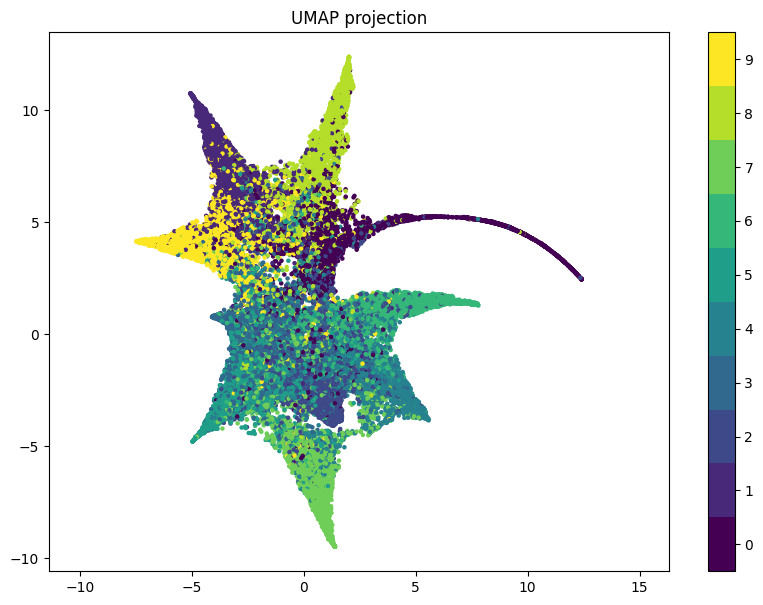

In [ ]:
# plot features
plot_umap(features,y_test)

In [ ]:
augmentation = transforms.Compose([
    #To do
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                   ])

In [ ]:
def generate_fgm_examples(model,data_loader,criterion):
    examples = []
    labels = []

    with tqdm(data_loader, desc ="   test") as test_tqdm:
        newmodel = FGSM(model, 0.3)
        for batch_idx, (inputs, targets) in enumerate(test_tqdm):
            inputs, targets = inputs.to(device), targets.to(device)
            #To do
            modified = newmodel(inputs, targets)
            modified = modified.detach().cpu()
            examples.append(modified)
            targets = targets.detach().cpu().numpy()
            labels.extend(targets)

    return examples,labels

In [ ]:
# get adversarial test data and label
newval_dataset = Cifar10Dataset(cifar_trainset, val_indices, transforms=augmentation)
newval_loader = torch.utils.data.DataLoader(newval_dataset, batch_size=128, shuffle=True)
advx_test,advy_test = generate_fgm_examples(model, newval_loader, criterion)

   test: 100%|██████████| 313/313 [01:04<00:00,  4.88it/s]


In [ ]:
# checking with adversarial test data
tloss, taccuracy = test(model, newval_loader, criterion, optimizer, attack = True)
print("test loss: ", tloss)
print("test accuracy: ", taccuracy)

   test: 100%|██████████| 313/313 [01:06<00:00,  4.69it/s]

test loss:  11.021705328846892
test accuracy:  6.91


In [ ]:
# get features and advy_test
features = []
model.eval()
for batch_idx, inputs in enumerate(advx_test):
        inputs = inputs.to(device)
        outputs = model(inputs, True)
        outputs = outputs.detach().cpu().numpy()
        features.append(outputs)
features = np.concatenate(features)
print(features.shape)
features = features.reshape(40000, 512)

(40000, 512, 1, 1)


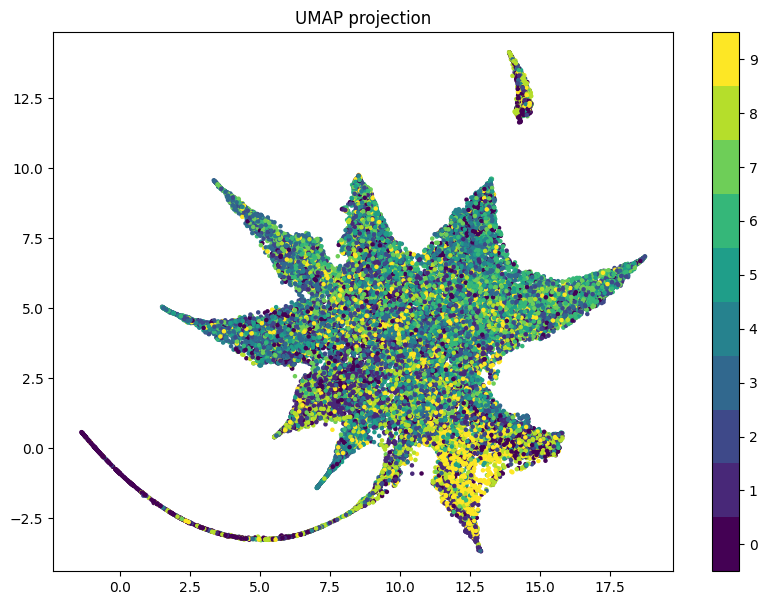

In [ ]:
# plot features
plot_umap(features,advy_test)

In [ ]:
#Train resnet18 using the adversarial examples
newtrain_dataset = Cifar10Dataset(cifar_trainset, train_indices, transforms=augmentation)
newtrain_loader = torch.utils.data.DataLoader(newtrain_dataset, batch_size=128, shuffle=True)
#advx_test,advy_test = generate_fgm_examples(model, newval_loader, criterion)

In [ ]:
# training with adversarial train data
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

loss2 = 0
accuracy2 = 0

for epoch in range(0, 100):
    loss2, accuracy2 = train(model, newtrain_loader, criterion, optimizer, attack = True)
    print("train loss: ", loss2)
    print("train accuracy: ", accuracy2)

   train: 100%|██████████| 79/79 [00:18<00:00,  4.33it/s]


train loss:  2.8544471324244634
train accuracy:  9.6


   train: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


train loss:  2.273469912854931
train accuracy:  14.67


   train: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


train loss:  2.245627409295191
train accuracy:  16.93


   train: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]


train loss:  2.2105577173112314
train accuracy:  19.08


   train: 100%|██████████| 79/79 [00:17<00:00,  4.39it/s]


train loss:  2.1515878861463524
train accuracy:  20.53


   train: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


train loss:  2.068029856380028
train accuracy:  24.59


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  1.9942031857333606
train accuracy:  28.53


   train: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


train loss:  1.9565982743154597
train accuracy:  29.46


   train: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


train loss:  1.8483664204802694
train accuracy:  34.66


   train: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


train loss:  1.7625254966035675
train accuracy:  37.67


   train: 100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


train loss:  1.58725269384022
train accuracy:  43.85


   train: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


train loss:  1.5196116408215294
train accuracy:  47.0


   train: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


train loss:  1.4390593555909168
train accuracy:  50.09


   train: 100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


train loss:  1.468842799150491
train accuracy:  48.73


   train: 100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


train loss:  1.3455347977107084
train accuracy:  52.95


   train: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


train loss:  1.254478407811515
train accuracy:  56.26


   train: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


train loss:  1.168487643139272
train accuracy:  59.22


   train: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


train loss:  1.097261923023417
train accuracy:  61.97


   train: 100%|██████████| 79/79 [00:17<00:00,  4.58it/s]


train loss:  1.0657478593572784
train accuracy:  63.05


   train: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


train loss:  1.0300700709789614
train accuracy:  64.39


   train: 100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


train loss:  0.9467445046086854
train accuracy:  67.19


   train: 100%|██████████| 79/79 [00:17<00:00,  4.47it/s]


train loss:  0.8781772640687001
train accuracy:  70.0


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.8381561018243621
train accuracy:  71.2


   train: 100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


train loss:  0.7902642790275284
train accuracy:  73.19


   train: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


train loss:  0.8456000761140751
train accuracy:  70.78


   train: 100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


train loss:  0.7721522201465655
train accuracy:  73.84


   train: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


train loss:  0.7628116320960129
train accuracy:  73.6


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  0.72911438006389
train accuracy:  75.63


   train: 100%|██████████| 79/79 [00:18<00:00,  4.38it/s]


train loss:  0.7343129919299597
train accuracy:  74.77


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.6326444665842419
train accuracy:  78.2


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  0.6077994259097909
train accuracy:  79.25


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.63578408239763
train accuracy:  78.64


   train: 100%|██████████| 79/79 [00:18<00:00,  4.37it/s]


train loss:  0.6213983527467221
train accuracy:  78.85


   train: 100%|██████████| 79/79 [00:17<00:00,  4.57it/s]


train loss:  0.5195554238331469
train accuracy:  82.67


   train: 100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


train loss:  0.5243002938318856
train accuracy:  82.29


   train: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


train loss:  0.4988008239601232
train accuracy:  83.0


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  0.46247940463355824
train accuracy:  84.92


   train: 100%|██████████| 79/79 [00:17<00:00,  4.49it/s]


train loss:  0.4679681106081492
train accuracy:  83.89


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.4587547035911415
train accuracy:  84.64


   train: 100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


train loss:  0.45762456859214395
train accuracy:  84.52


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.4307814442281482
train accuracy:  85.53


   train: 100%|██████████| 79/79 [00:18<00:00,  4.31it/s]


train loss:  0.4951059184496916
train accuracy:  83.07


   train: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


train loss:  0.4183169780652734
train accuracy:  85.93


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  0.39108000054389613
train accuracy:  86.65


   train: 100%|██████████| 79/79 [00:17<00:00,  4.50it/s]


train loss:  0.32592021400415444
train accuracy:  88.79


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  0.3444110383338566
train accuracy:  88.79


   train: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]


train loss:  0.3720122143814835
train accuracy:  87.36


   train: 100%|██████████| 79/79 [00:17<00:00,  4.44it/s]


train loss:  0.3454238870475866
train accuracy:  88.66


   train: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


train loss:  0.3532370832524722
train accuracy:  88.04


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  0.39247467981863626
train accuracy:  87.16


   train: 100%|██████████| 79/79 [00:17<00:00,  4.56it/s]


train loss:  0.4304519474883623
train accuracy:  85.88


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  0.41254514493519745
train accuracy:  85.95


   train: 100%|██████████| 79/79 [00:17<00:00,  4.49it/s]


train loss:  0.3636294292120994
train accuracy:  87.95


   train: 100%|██████████| 79/79 [00:17<00:00,  4.61it/s]


train loss:  0.29948856728740886
train accuracy:  89.77


   train: 100%|██████████| 79/79 [00:17<00:00,  4.44it/s]


train loss:  0.3493284177553805
train accuracy:  88.61


   train: 100%|██████████| 79/79 [00:17<00:00,  4.57it/s]


train loss:  0.38933743687370154
train accuracy:  86.79


   train: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


train loss:  0.33151308437691457
train accuracy:  88.6


   train: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]


train loss:  0.3242252940618539
train accuracy:  89.34


   train: 100%|██████████| 79/79 [00:17<00:00,  4.39it/s]


train loss:  0.30582130313674105
train accuracy:  89.84


   train: 100%|██████████| 79/79 [00:17<00:00,  4.50it/s]


train loss:  0.30894543343706976
train accuracy:  89.81


   train: 100%|██████████| 79/79 [00:27<00:00,  2.91it/s]


train loss:  0.2750748551533192
train accuracy:  90.77


   train: 100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


train loss:  0.3043932439405707
train accuracy:  89.57


   train: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


train loss:  0.30259902963909924
train accuracy:  89.73


   train: 100%|██████████| 79/79 [00:17<00:00,  4.44it/s]


train loss:  0.3956658242246773
train accuracy:  86.4


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.35149442366784134
train accuracy:  88.35


   train: 100%|██████████| 79/79 [00:19<00:00,  4.04it/s]


train loss:  0.27676644581782667
train accuracy:  90.67


   train: 100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


train loss:  0.27465137462072736
train accuracy:  91.26


   train: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


train loss:  0.29464189981735206
train accuracy:  90.78


   train: 100%|██████████| 79/79 [00:17<00:00,  4.56it/s]


train loss:  0.26233050368631944
train accuracy:  91.04


   train: 100%|██████████| 79/79 [00:18<00:00,  4.32it/s]


train loss:  0.2785293346718897
train accuracy:  90.46


   train: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


train loss:  0.2664794995437694
train accuracy:  91.56


   train: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


train loss:  0.24584728149296362
train accuracy:  91.91


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.27844054996967316
train accuracy:  91.07


   train: 100%|██████████| 79/79 [00:17<00:00,  4.50it/s]


train loss:  0.292732752576659
train accuracy:  90.33


   train: 100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


train loss:  0.23237803031372117
train accuracy:  92.64


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.23813281698694713
train accuracy:  92.53


   train: 100%|██████████| 79/79 [00:17<00:00,  4.46it/s]


train loss:  0.25733484044859684
train accuracy:  91.27


   train: 100%|██████████| 79/79 [00:17<00:00,  4.54it/s]


train loss:  0.2918002846874768
train accuracy:  90.16


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]


train loss:  0.19923203664867184
train accuracy:  93.42


   train: 100%|██████████| 79/79 [00:17<00:00,  4.57it/s]


train loss:  0.2069146334181858
train accuracy:  93.18


   train: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


train loss:  0.24746082430776162
train accuracy:  91.46


   train: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


train loss:  0.22166141867637634
train accuracy:  92.97


   train: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


train loss:  0.18228001251250883
train accuracy:  93.93


   train: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


train loss:  0.18972083978071996
train accuracy:  93.8


   train: 100%|██████████| 79/79 [00:17<00:00,  4.41it/s]


train loss:  0.21270727413364604
train accuracy:  92.82


   train: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


train loss:  0.19849863016529928
train accuracy:  93.36


   train: 100%|██████████| 79/79 [00:17<00:00,  4.40it/s]


train loss:  0.18825533825762664
train accuracy:  94.09


   train: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


train loss:  0.17868512708552275
train accuracy:  94.1


   train: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


train loss:  0.1727145345339292
train accuracy:  94.45


   train: 100%|██████████| 79/79 [00:17<00:00,  4.44it/s]


train loss:  0.16872243795402442
train accuracy:  94.24


   train: 100%|██████████| 79/79 [00:17<00:00,  4.53it/s]


train loss:  0.2129242115571529
train accuracy:  92.67


   train: 100%|██████████| 79/79 [00:17<00:00,  4.45it/s]


train loss:  0.1820221677233901
train accuracy:  94.04


   train: 100%|██████████| 79/79 [00:17<00:00,  4.52it/s]


train loss:  0.19287652169837605
train accuracy:  93.35


   train: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


train loss:  0.16790244869793516
train accuracy:  94.38


   train: 100%|██████████| 79/79 [00:17<00:00,  4.57it/s]


train loss:  0.17271681676937056
train accuracy:  93.74


   train: 100%|██████████| 79/79 [00:17<00:00,  4.42it/s]


train loss:  0.17864122406779964
train accuracy:  93.83


   train: 100%|██████████| 79/79 [00:17<00:00,  4.55it/s]


train loss:  0.22993026400291466
train accuracy:  93.1


   train: 100%|██████████| 79/79 [00:18<00:00,  4.28it/s]


train loss:  0.2824490670161911
train accuracy:  90.8


   train: 100%|██████████| 79/79 [00:17<00:00,  4.51it/s]


train loss:  0.22648540450425086
train accuracy:  92.76


   train: 100%|██████████| 79/79 [00:17<00:00,  4.43it/s]

train loss:  0.2150116609998896
train accuracy:  93.31


In [ ]:
# test with normal test data
tloss, taccuracy = test(model, val_loader, criterion, optimizer)
print("test loss: ", tloss)
print("test accuracy: ", taccuracy)

   test: 100%|██████████| 313/313 [00:14<00:00, 22.13it/s]

test loss:  9.395215307180873
test accuracy:  17.5175


In [ ]:
# get features and y_test
features = []
y_test = []
model.eval()
with tqdm(val_loader, desc ="   test") as val_tqdm:
    for batch_idx, (inputs, targets) in enumerate(val_tqdm):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs, True)
        outputs = outputs.detach().cpu().numpy()
        features.append(outputs)
        targets = targets.detach().cpu().numpy()
        y_test.extend(targets)
features = np.concatenate(features)
features = features.reshape(40000, 512)

   test: 100%|██████████| 313/313 [00:14<00:00, 21.14it/s]


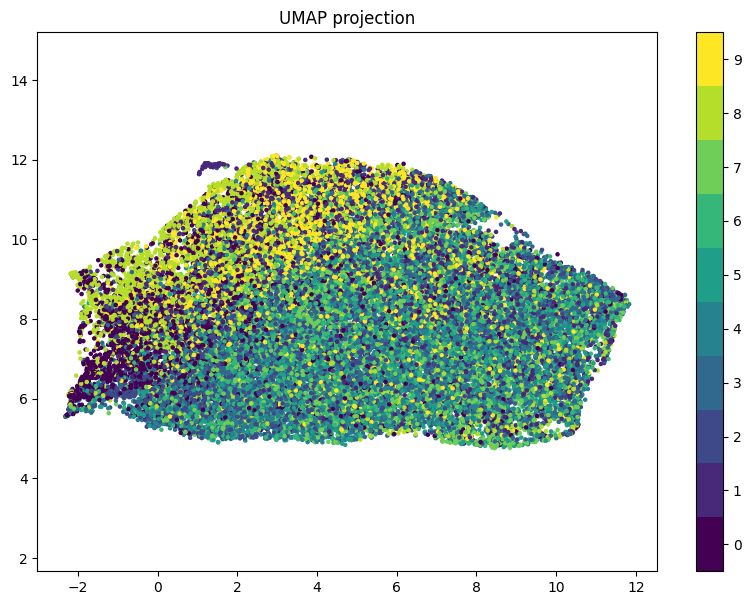

In [ ]:
# plot features
plot_umap(features,y_test)

In [ ]:
# checking with adversarial test data
tloss, taccuracy = test(model, newval_loader, criterion, optimizer, attack = True)
print("test loss: ", tloss)
print("test accuracy: ", taccuracy)

   test: 100%|██████████| 313/313 [01:07<00:00,  4.67it/s]

test loss:  2.55384344300523
test accuracy:  47.1825


In [ ]:
# get features
features = []
model.eval()
for batch_idx, inputs in enumerate(advx_test):
        inputs = inputs.to(device)
        outputs = model(inputs, True)
        outputs = outputs.detach().cpu().numpy()
        features.append(outputs)
features = np.concatenate(features)
features = features.reshape(40000, 512)

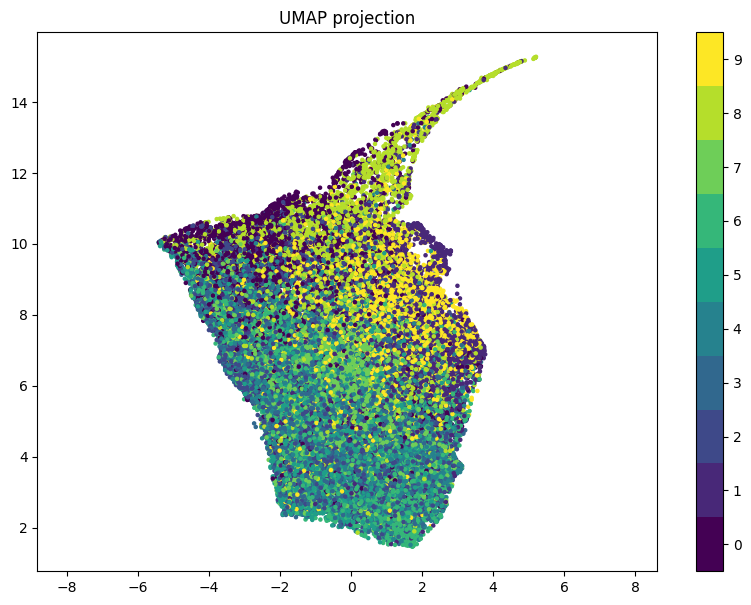

In [ ]:
# plot features
plot_umap(features,advy_test)